_Navigation_

In [3]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

# Task

Telecom operator company decides to predict a clients' churn. If the company finds out that the customer wills to quit, he will be offered with special promocodes and personal options. Given data includes personal, tariff and contract information about some of it's clients.

### Provided service

There are two major services by the company: 

1. Landline telephone service. It is possible to connect the phone to several lines at the same time.
2. The Internet. Connection can be of two types: via a telephone line (DSL (*digital subscriber line*), or fiber optic cable (*Fiber optic*).

Also:

- Internet security: antivirus (*Device Protection*) and blocking unsafe sites service (*OnlineSecurity*);
- Personal technical support line (*TechSupport*);
- Cloud file storage for data backup (*Online Backup*);
- Streaming TV (*Streaming TV*) and movie catalog (*StreamingMovies*).

Customers can pay for services every month or sign a contract for 1-2 years. Various payment methods and the possibility of receiving an electronic receipt are available.

### Data description

Data consists of files received from different sources:

- `contract.csv` — information about the contract;
- `personal.csv` — the personal data of the client;
- `internet.csv` — information about Internet services;
- `phone.csv` — information about telephony services.

In all files, the `customerID` column contains the client code.

Information about contracts is current as of February 1, 2020.

# Stack

In [4]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

___

# First look

In [5]:
contract = pd.read_csv('contract.csv')
internet = pd.read_csv('internet.csv')
personal = pd.read_csv('personal.csv')
phone = pd.read_csv('phone.csv')

### Contract

In [6]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [7]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


First dataset consists of the info about 7000 clients. Data types should be converted.

Also data encoding will be needed for ML

### internet

In [8]:
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


Same thing- data types should be converted to numerical. There are less entries than in the `contract` db: not all clients use the internet service

### personal

In [10]:
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [11]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


### phone

In [12]:
phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [13]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


## After first look

In general, there are 7043 entries with clients data, but tables with services include less rows- it depends whether the client uses or doesn't use the service

Data has to be preprocessed: for the analysis and for ML

`customerID` will help to merge the data

___

## Preprocessing

### Contract

__Data types__

In [14]:
# Dealing with the date columns: converting them to datetime and preparing them for new features creating

contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y.%m.%d')
contract.loc[contract['EndDate']  != 'No', 'actualend'] = contract['EndDate']

contract['actualend'] = pd.to_datetime(contract['actualend'], format='%Y.%m.%d %H:%M:%S')

contract['live_contract'] = contract['actualend'].sub(contract['BeginDate'], axis=0)

contract = contract.drop(columns = ['EndDate'])

In [15]:
contract['TotalCharges'] = contract['TotalCharges'].str.replace(',', '')


In [16]:
def fast_num_conversion(s):
    
    f_convert = lambda x: re.sub('[$\-,\| ]', '', x)
    f_float = lambda x: float(x) if x!='' else np.NaN
    vals = {curr:f_float(f_convert(curr)) for curr in s.unique()}
    return s.map(vals)

In [17]:
contract['TotalCharges'] = fast_num_conversion(contract['TotalCharges'])

Creating a new columns with the total contract duration, if it is finished. In other words, for how long a client used to be a (good guy) client

In [18]:
contract['live_contract'] = contract['live_contract'].dt.days

In [19]:
contract

,customerID,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,actualend,live_contract
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,NaT,NaN
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,1889.50,NaT,NaN
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,2019-12-01,61.0
3,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1840.75,NaT,NaN
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,151.65,2019-11-01,61.0
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,One year,Yes,Mailed check,84.80,1990.50,NaT,NaN
7039,2234-XADUH,2014-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,NaT,NaN
7040,4801-JZAZL,2019-03-01,Month-to-month,Yes,Electronic check,29.60,346.45,NaT,NaN
7041,8361-LTMKD,2019-07-01,Month-to-month,Yes,Mailed check,74.40,306.60,2019-11-01,123.0


In [20]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
actualend           1869 non-null datetime64[ns]
live_contract       1869 non-null float64
dtypes: datetime64[ns](2), float64(3), object(4)
memory usage: 495.3+ KB


### internet

In [21]:
internet.drop_duplicates()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [22]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


__Nothing is to be done here right now. Later encoding is to be performed, for machine learning__

### personal

In [23]:
personal.drop_duplicates()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [24]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


__Same. No preprocessing needed: no NaN values, no duplicates__

### phone

In [25]:
phone.drop_duplicates()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


__Let's roll out some EDA__

___

# EDA

### Total charged amount

Hist

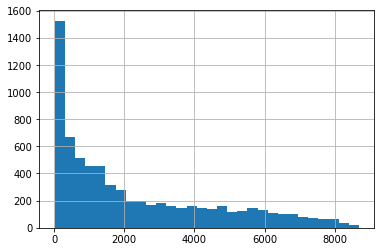

In [26]:
contract['TotalCharges'].hist(bins = 30)

Boxplot

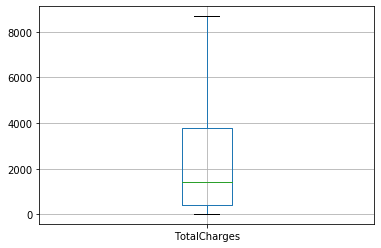

In [27]:
contract.boxplot('TotalCharges')

No outliers, which is good

Half of the clients payid less than 2000 (whatever the currency is) for the whole calculation period

### Monthly charged amount

Hist

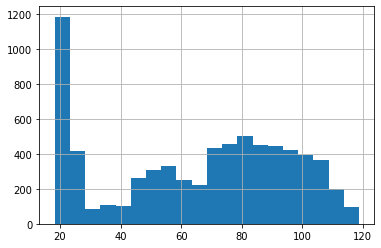

In [28]:
contract['MonthlyCharges'].hist(bins = 20)

The histogram for a larger number of bins indicates that the data is discrete, which is logical - the monthly fee should not vary from client to client as a continuous value

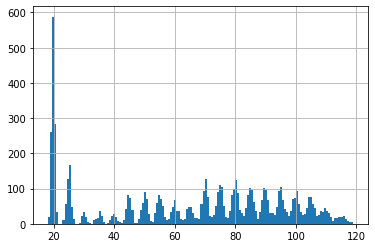

In [29]:
contract['MonthlyCharges'].hist(bins = 150)

Boxplot

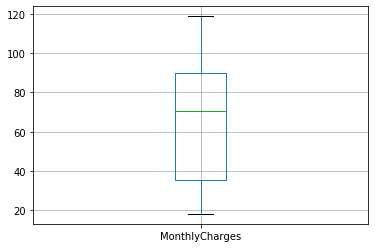

In [30]:
contract.boxplot('MonthlyCharges')

The median monthly check is $ 65. At the same time, the majority of customers don't pay much

_Let's take a closer look at why customers pay so differently and whether the value of the monthly receipt depends on the services provided_

__Average Charges and payment method__

In [31]:
contract.pivot_table(index = 'Type', values = 'MonthlyCharges', aggfunc = ['mean', 'median'])

,mean,median
,MonthlyCharges,MonthlyCharges
Type,,
Month-to-month,66.398490,73.25
One year,65.048608,68.75
Two year,60.770413,64.35


The dependence of the average receipt on the type of payment is insignificant.

There is no more interesting data in the contract table. It's time to merge other tables and see what they can tell us

#### MonthlyCharges and the internet connection

In [32]:
contract.merge(internet, on='customerID', how='left').pivot_table(
    index = ['InternetService'], values = 'MonthlyCharges', aggfunc = ['mean', 'median'])

,mean,median
,MonthlyCharges,MonthlyCharges
InternetService,,
DSL,58.102169,56.150
Fiber optic,91.500129,91.675


Fiber optic is more expensive. Customers pay almost twice as much for Fiber Optic as for DSL, which is logical: the service is more modern and faster in Connection speed. In General, the amount of the receipt becomes larger the more additional services the user connects to the Internet

In [33]:
contract.merge(internet, on='customerID', how='left').pivot_table(
    index = [
        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
    values = 'MonthlyCharges').sort_values(
    by = 'MonthlyCharges')

MonthlyCharges
InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies                
DSL             No             No           No               No          No          No                    40.277721
                                                             Yes         No          No                    44.731757
                               Yes          No               No          No          No                    44.793814
                               No           Yes              No          No          No                    46.567000
                Yes            No           No               No          No          No                    47.075943
...                                                                                                              ...
Fiber optic     Yes            Yes          No               Yes         Yes         Yes                  107.889394
                               No           Yes              Yes         Yes         Yes                  108.446154
                               Yes          Yes              No          Yes         Yes                  108.793750
                No             Yes          Yes              Yes         Yes         Yes                  109.110092
                Yes            Yes          Yes              Yes         Yes         Yes                  114.311702

[128 rows x 1 columns]

_The most precious thing is to hear Yes to all questions (quote)_

#### Dial Services

In the table with telephone services, there is only a column: whether the client is connected to several lines at the same time. Multiple lines bring a larger check

In [34]:
contract.merge(phone, on='customerID', how='left').pivot_table(
    index = ['MultipleLines'], values = 'MonthlyCharges')

,MonthlyCharges
MultipleLines,
No,54.195059
Yes,82.036974


#### And personal data

Table, similar to the internet one, but with personal data. Let's take a look at the average bill

__Single men pay the least (60 per month), non - single men- most of all (68 per month):__

In [35]:
contract.merge(personal, on='customerID', how='left').pivot_table(
    index = ['Partner','gender'
            ], values = 'MonthlyCharges')

MonthlyCharges
Partner gender                
No      Female       63.874111
        Male         60.058854
Yes     Female       66.622630
        Male         68.912398

__Senior Citizens, surprisingly, pay more than people of pre-retirement age: 62 vs 80:__

In [36]:
contract.merge(personal, on='customerID', how='left').pivot_table(
    index = ['SeniorCitizen'
            ], values = 'MonthlyCharges')

,MonthlyCharges
SeniorCitizen,
0,61.847441
1,79.820359


__Customers with dependents pay less for Telecom than customers without them: 60 and 67 respectively__

In [37]:
contract.merge(personal, on='customerID', how='left').pivot_table(
    index = ['Dependents'
            ], values = 'MonthlyCharges')

,MonthlyCharges
Dependents,
No,67.002808
Yes,59.522156


### About the monthly charges

- The data is discrete enough, which is logical - the monthly fee should not vary from client to client as a continuous value - users pay for services at established prices
- The median monthly check is 65

Let's take a closer look at why customers pay so differently and whether the value of the monthly receipt depends on the services provided:

- On average, customers pay almost twice as much for Fiber Optic as for DSL, which is logical: the service is more modern and faster in connection speed. In General, the amount of the receipt becomes larger the more additional services the user connects to the Internet
- In the table with telephone services, there is only a column whether the client is connected to several lines at the same time. Multiple lines bring a larger check
- Single men pay the least (60 per month), non - single men pay most of all (68 per month). In general, the average monthly payment increases from the presence of a partner
- Clients with dependents on average pay less for Telecom than clients without them: 60 and 67 respectively
- Senior Citizens, surprisingly, pay more than people of pre-retirement age: 62 against 80. Maybe they manage to be fooled by the company managers

### The main question: churn

Previously, during preprocessing, `live_contract` column was created. Values of `live_contract` are either abscent, or show the result of substraction of Begin Date and the End Date of the contract, in days

#### `live contract` for those who quit

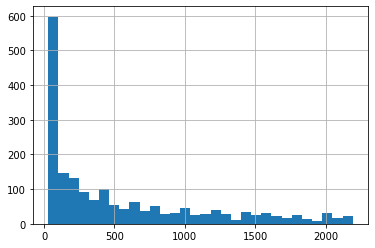

In [38]:
contract['live_contract'].hist(bins = 30)

The majority quits in the first year, but old, loyal customers also sometimes get lost. The distribution looks like a Poisson distribution

In [39]:
contract['live_contract'].describe()

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: live_contract, dtype: float64

Half of the clients actually quit within the first 300 days of signing the contract. At the same time, the average time to use the company's services is twice longer - 600 days, thanks to those loyal customers who left after 2000 days

#### Typical churn...

In [40]:
churn = contract.loc[contract['live_contract'].notna()]

churn.head(3)

,customerID,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,actualend,live_contract
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,2019-12-01,61.0
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,151.65,2019-11-01,61.0
5,9305-CDSKC,2019-03-01,Month-to-month,Yes,Electronic check,99.65,820.50,2019-11-01,245.0


__...pays mothly__

Contract types for all clients

In [41]:
contract['Type'].value_counts(normalize=True) * 100

Month-to-month    55.019168
Two year          24.066449
One year          20.914383
Name: Type, dtype: float64

Contract types for those who quit

In [42]:
churn['Type'].value_counts(normalize=True) * 100

Month-to-month    88.550027
One year           8.881755
Two year           2.568218
Name: Type, dtype: float64

Departed clients often have a monthly payment for the contract - with a monthly payment, it is easier to leave

__...pays more__

In [43]:
contract['MonthlyCharges'].mean()

64.76169246059922

In [44]:
churn['MonthlyCharges'].mean()

74.4413322632423

__... but in total paid less- because he quit__

In [45]:
contract['TotalCharges'].mean()

2283.3004408418697

In [46]:
churn['TotalCharges'].mean()

1531.7960941680035

2283 vs 1531. It's an expensive thing to lose a client

__...pays with Electronic Check__

In [47]:
contract['PaymentMethod'].value_counts(normalize=True) * 100

Electronic check             33.579441
Mailed check                 22.887974
Bank transfer (automatic)    21.922476
Credit card (automatic)      21.610109
Name: PaymentMethod, dtype: float64

In [48]:
churn['PaymentMethod'].value_counts(normalize=True) * 100

Electronic check             57.303371
Mailed check                 16.479401
Bank transfer (automatic)    13.804173
Credit card (automatic)      12.413055
Name: PaymentMethod, dtype: float64

Electronic check: Among those who quit 75% and 60% among all

In [49]:
contract['PaperlessBilling'].value_counts(normalize=True) * 100

Yes    59.221922
No     40.778078
Name: PaperlessBilling, dtype: float64

In [50]:
churn['PaperlessBilling'].value_counts(normalize=True) * 100

Yes    74.906367
No     25.093633
Name: PaperlessBilling, dtype: float64

More than half of the clients who left paid for services electronically. At the same time, only a third of all clients in the pay electronically.

"Electronic" clients go to competitors more often

#### Churn and personal data

__No bounds with gender__

In [51]:
contract.merge(personal, on='customerID', how='left')['gender'].value_counts(normalize=True) * 100

Male      50.47565
Female    49.52435
Name: gender, dtype: float64

In [52]:
churn.merge(personal, on='customerID', how='left')['gender'].value_counts(normalize=True) * 100

Female    50.24077
Male      49.75923
Name: gender, dtype: float64

There are only two genders: churn and non-churn.

__Dependants keep the client from quitting__

In [53]:
contract.merge(personal, on='customerID', how='left')['Dependents'].value_counts(normalize=True) * 100

No     70.041176
Yes    29.958824
Name: Dependents, dtype: float64

In [54]:
churn.merge(personal, on='customerID', how='left')['Dependents'].value_counts(normalize=True) * 100

No     82.557517
Yes    17.442483
Name: Dependents, dtype: float64

30% among all clients have dependats. And only 17% among those who quit

__There are more Senior Citizens among those who quit, compared to the united sample__

In [55]:
contract.merge(personal, on='customerID', how='left')['SeniorCitizen'].value_counts(normalize=True) * 100

0    83.785319
1    16.214681
Name: SeniorCitizen, dtype: float64

In [56]:
churn.merge(personal, on='customerID', how='left')['SeniorCitizen'].value_counts(normalize=True) * 100

0    74.531835
1    25.468165
Name: SeniorCitizen, dtype: float64

16 percent among all VS 25 among those who left. Perhaps this is due to non-economic reasons, such as death (?). Important column for a future predictive model

__Leaving client less probably has a partner__

In [57]:
contract.merge(personal, on='customerID', how='left')['Partner'].value_counts(normalize=True) * 100

No     51.69672
Yes    48.30328
Name: Partner, dtype: float64

In [58]:
churn.merge(personal, on='customerID', how='left')['Partner'].value_counts(normalize=True) * 100

No     64.205457
Yes    35.794543
Name: Partner, dtype: float64

64% of the clients who quit are unmarried, compared to only half of them in the united sample. The situation is similar to dependents - family ties seem to keep the client from leaving.

__We can create an additional column where the 1 will be for those who have both a partner and children. More connections, more loyalty to the brand.__

### About the churn

Previously, in preprocessing, a column was created with the time of using the company's services, the "lifetime" of the company's client

- Most of them leave in the first year, but old, loyal customers are also sometimes lost. The distribution looks like a Poisson distribution

- Average departed client: 
 - Prefer a monthly payment type
    - Pays by electronic payment, with an electronic check
- - is more Likely to have no children and no partner
    - More often it turns out to A Senior Citizen

___

# EDA Summary

__In general__, there are 7043 entries with clients data, but tables with services include less rows- it depends whether the client uses or doesn't use the service

Data has to be preprocessed: for the analysis and for ML

`customerID` will help to merge the data

_There are no outliers and duplicates. There are gaps caused by the abscence of the service usage of the clients_

__Creating__ a new column with the contract duration if the contract is closed. In days

__Charges__

- The data is discrete enough, which is logical - the monthly fee should not vary from client to client as a continuous value - users pay for services at established prices
- The median monthly check is 65

Let's take a closer look at why customers pay so differently and whether the value of the monthly receipt depends on the services provided:

- On average, customers pay almost twice as much for Fiber Optic as for DSL, which is logical: the service is more modern and faster in connection speed. In General, the amount of the receipt becomes larger the more additional services the user connects to the Internet
- In the table with telephone services, there is only a column whether the client is connected to several lines at the same time. Multiple lines bring a larger check
- Single men pay the least (60 per month), non - single men pay most of all (68 per month). In general, the average monthly payment increases from the presence of a partner
- Clients with dependents on average pay less for Telecom than clients without them: 60 and 67 respectively
- Senior Citizens, surprisingly, pay more than people of pre-retirement age: 62 against 80. Maybe they manage to be fooled by the company managers

__Churn__

Previously, in preprocessing, a column was created with the time of using the company's services, the "lifetime" of the company's client

- Most of them leave in the first year, but old, loyal customers are also sometimes lost. The distribution looks like a Poisson distribution

- Average departed client: 
 - Prefer a monthly payment type
    - Pays by electronic payment, with an electronic check
- is more Likely to have no children and no partner
    - More often it turns out to A Senior Citizen

# Machine learning

## Data formation

Merging all data into one table

In [59]:
for_ml = contract.merge(personal, on='customerID', how='left')

for_ml = for_ml.merge(phone, on='customerID', how='left')

for_ml= for_ml.merge(internet, on='customerID', how='left')

for_ml.head(3)

,customerID,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,actualend,live_contract,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,NaT,NaN,Female,...,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,1889.50,NaT,NaN,Male,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,2019-12-01,61.0,Male,...,No,No,No,DSL,Yes,Yes,No,No,No,No


`live_contract` gets the data for all clients. Those who haven't left the company get the contract duration as if they left on the parsing: 1st of February 2020

## Target

The clients whose `live_contract` is empty haven't stopped using our telecom services. For them target is 0, for those who decided to quit- 1. After filling the target values the `live_contract` column is filled

In [60]:
for_ml['target'] = 0
for_ml.loc[for_ml['live_contract'].notna(), 'target'] = 1

In [61]:
for_ml

,customerID,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,actualend,live_contract,gender,...,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,target
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,NaT,NaN,Female,...,No,NaN,DSL,No,Yes,No,No,No,No,0
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,1889.50,NaT,NaN,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,0
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,2019-12-01,61.0,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,1
3,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1840.75,NaT,NaN,Male,...,No,NaN,DSL,Yes,No,Yes,Yes,No,No,0
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,151.65,2019-11-01,61.0,Female,...,No,No,Fiber optic,No,No,No,No,No,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,One year,Yes,Mailed check,84.80,1990.50,NaT,NaN,Male,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,0
7039,2234-XADUH,2014-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,NaT,NaN,Female,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,0
7040,4801-JZAZL,2019-03-01,Month-to-month,Yes,Electronic check,29.60,346.45,NaT,NaN,Female,...,Yes,NaN,DSL,Yes,No,No,No,No,No,0
7041,8361-LTMKD,2019-07-01,Month-to-month,Yes,Mailed check,74.40,306.60,2019-11-01,123.0,Male,...,No,Yes,Fiber optic,No,No,No,No,No,No,1


In [62]:
date_of_review = pd.to_datetime('2020-02-01', format='%Y-%m-%d')

In [63]:
for_ml.loc[for_ml['live_contract'].notna(), 'live_contract'] = for_ml['actualend'].sub(for_ml['BeginDate'], axis=0)
for_ml.loc[for_ml['live_contract'].isna(), 'live_contract'] = date_of_review - for_ml['BeginDate']

for_ml.loc[for_ml['live_contract'].notna(), 'live_contract'] = for_ml['actualend'].sub(for_ml['BeginDate'], axis=0)
for_ml.loc[for_ml['live_contract'].isna(), 'live_contract'] = date_of_review - for_ml['BeginDate']

In [64]:
for_ml['live_contract'] = for_ml['live_contract'].dt.days

In [65]:
for_ml.head(3)

,customerID,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,actualend,live_contract,gender,...,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,target
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,NaT,31,Female,...,No,NaN,DSL,No,Yes,No,No,No,No,0
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,1889.50,NaT,1036,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,0
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,2019-12-01,61,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,1


Deleting not needed columns: `BeginDate`, `actualend`, `customerID`

In [66]:
for_ml = for_ml.drop(columns = ['BeginDate', 'actualend', 'customerID'])

## Gaps

In [67]:
for_ml = for_ml.fillna(0)

In [68]:
for_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
live_contract       7043 non-null int64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
target              7043 non-null int64
dtypes: float64(2), int64(3), object(14)
memory usage: 1.4+ MB


## New features

### "family_guy"

- equals to 1 of the client has dependants and a partner at the same time

In [69]:
for_ml['familyguy'] = 0

for_ml.loc[(for_ml['Partner'] == 'Yes') & (for_ml['Dependents'] == 'Yes'), 'familyguy'] = 1

for_ml.tail()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,live_contract,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,target,familyguy
7038,One year,Yes,Mailed check,84.80,1990.50,730,Male,0,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,0,1
7039,One year,Yes,Credit card (automatic),103.20,7362.90,2191,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,0,1
7040,Month-to-month,Yes,Electronic check,29.60,346.45,337,Female,0,Yes,Yes,0,DSL,Yes,No,No,No,No,No,0,1
7041,Month-to-month,Yes,Mailed check,74.40,306.60,123,Male,1,Yes,No,Yes,Fiber optic,No,No,No,No,No,No,1,0
7042,Two year,Yes,Bank transfer (automatic),105.65,6844.50,2010,Male,0,No,No,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,0,0


## Encoding

Function for data formating: 1 for each 'Yes', 0 for each 'No'

In [70]:
def no_to_zero_yes_to_one(data, columns_given):
    for column in columns_given:
        data.loc[data[column] == 'No', column] = 0
        data.loc[data[column] == 'Yes', column] = 1

Columns to apply the function to

In [71]:
needed_to_change = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "Partner", "Dependents", "MultipleLines",
                    "TechSupport","StreamingTV","StreamingMovies"]

In [72]:
no_to_zero_yes_to_one(for_ml, needed_to_change)

In [73]:
for_ml

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,live_contract,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,target,familyguy
0,Month-to-month,Yes,Electronic check,29.85,29.85,31,Female,0,1,0,0,DSL,0,1,0,0,0,0,0,0
1,One year,No,Mailed check,56.95,1889.50,1036,Male,0,0,0,0,DSL,1,0,1,0,0,0,0,0
2,Month-to-month,Yes,Mailed check,53.85,108.15,61,Male,0,0,0,0,DSL,1,1,0,0,0,0,1,0
3,One year,No,Bank transfer (automatic),42.30,1840.75,1371,Male,0,0,0,0,DSL,1,0,1,1,0,0,0,0
4,Month-to-month,Yes,Electronic check,70.70,151.65,61,Female,0,0,0,0,Fiber optic,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,Yes,Mailed check,84.80,1990.50,730,Male,0,1,1,1,DSL,1,0,1,1,1,1,0,1
7039,One year,Yes,Credit card (automatic),103.20,7362.90,2191,Female,0,1,1,1,Fiber optic,0,1,1,0,1,1,0,1
7040,Month-to-month,Yes,Electronic check,29.60,346.45,337,Female,0,1,1,0,DSL,1,0,0,0,0,0,0,1
7041,Month-to-month,Yes,Mailed check,74.40,306.60,123,Male,1,1,0,1,Fiber optic,0,0,0,0,0,0,1,0


In [74]:
encoder = OrdinalEncoder()
for_ml[[
    "Type","PaperlessBilling", "PaymentMethod", "gender"]] = (
    
    encoder.fit_transform(for_ml[[
    "Type","PaperlessBilling", "PaymentMethod", "gender"]]))

`Internet_service` has three different values: dsl, fiber optic и NaN- for those who don't use the internet services. Solving them with get_dummies

In [75]:
for_ml = pd.get_dummies(for_ml, drop_first=True)

## Data:

Having a sample of 7043 lines and 21 columns with data. Let's train_test_split them

## Test sample

sized of 0.25 from all data

In [76]:
df_train, df_test = train_test_split(for_ml, test_size=0.25, random_state=12345)

In [77]:
features_train = df_train.drop(columns = ['target'])

target_train = df_train['target']

In [78]:
features_test = df_test.drop(columns = ['target'])

target_test = df_test['target']

## learning

Commenting this to avoid too much data outputs in github.

In [1]:
#%%time
#CB_model = CatBoostClassifier()
#grid = {'learning_rate': [0.03, 0.1],
#        'depth': [4, 6, 10],
#        'l2_leaf_reg': [5, 7, 9],
#        'iterations': [1000]}


#CV_model = GridSearchCV(estimator=CB_model, param_grid=grid, cv= 5, scoring = 'roc_auc')

#CV_model.fit(features_train, target_train)
#print(CV_model.best_params_)

The best CV score:

In [80]:
print(CV_model.best_score_)

0.9124184946350901


Parameters: iterations=1000, depth=4, l2_leaf_reg=5, learning_rate=0.1

In [81]:
%%time
CB_model = CatBoostClassifier(iterations=1000, depth=4, l2_leaf_reg=5, learning_rate=0.1)
CB_model.fit(features_train, target_train)
CB_model_prediction = CB_model.predict_proba(features_test)

0:	learn: 0.6302528	total: 2.79ms	remaining: 2.79s
1:	learn: 0.5817209	total: 5.7ms	remaining: 2.84s
2:	learn: 0.5479317	total: 8.39ms	remaining: 2.79s
3:	learn: 0.5183064	total: 11.4ms	remaining: 2.84s
4:	learn: 0.4947925	total: 14.4ms	remaining: 2.87s
5:	learn: 0.4775807	total: 17.1ms	remaining: 2.84s
6:	learn: 0.4643599	total: 21.3ms	remaining: 3.02s
7:	learn: 0.4528529	total: 24.2ms	remaining: 3s
8:	learn: 0.4433994	total: 27.9ms	remaining: 3.08s
9:	learn: 0.4361265	total: 31.4ms	remaining: 3.11s
10:	learn: 0.4298161	total: 35.6ms	remaining: 3.2s
11:	learn: 0.4253347	total: 39ms	remaining: 3.21s
12:	learn: 0.4206260	total: 42ms	remaining: 3.19s
13:	learn: 0.4167591	total: 45.9ms	remaining: 3.23s
14:	learn: 0.4137052	total: 49.7ms	remaining: 3.26s
15:	learn: 0.4109908	total: 53.7ms	remaining: 3.3s
16:	learn: 0.4087403	total: 57.3ms	remaining: 3.32s
17:	learn: 0.4067863	total: 60.8ms	remaining: 3.31s
18:	learn: 0.4045887	total: 63.5ms	remaining: 3.28s
19:	learn: 0.4028405	total: 68ms

## Metrics

In [82]:
auc_roc = roc_auc_score(target_test, CB_model_prediction[:,1])

In [83]:
auc_roc

0.9195410777689259

__accuracy with test sample__:

In [84]:
accuracy_score(CB_model.predict(features_test), target_test)

0.8801817149346962

# Machine Learning Summary

Achieved roc-auc - 0.91+

Great result for such a task: the excellent mark from the reviewer is given when you achieve roc-auc > 0.88

Order:
- __Target__: The clients whose `live_contract` is empty haven't stopped using our telecom services. For them target is 0, for those who decided to quit- 1. After filling the target values the `live_contract` column is filled
- `live_contract` is filled with all the data: those who has had `NaN` now has the contract duration as a result of subtraction of the beginning date and 1st of February 2020
- __Gaps__: All `NaN`s are filled with zeros because the service of this column is not provided. All 'Yes' and 'No" are also converted to 1s and 0s
- __New features__ Family_guy: equals to 1 if the client has dependants and a spouse at the same time
- Test sample has the size of 0.25 of all data set
- __Learning__
    - catboostclassifier(), parameters are chosen using gridsearchCV
    - Test sample auc-roc = 0.91+
    
    _accuracy is 88%_